# 패키지 로딩

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import numpy as np
import pandas as pd
from geopy.distance import great_circle
import os
import folium
from haversine import haversine
import matplotlib.pyplot as plt
#import pydeck as pdk
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')

# 데이터 로딩

In [2]:
# 한국에서 홍콩

KR2HK = os.listdir('./KH/')

KR2HK_list = []
for file in KR2HK:
    KR2HK_list.append(pd.read_csv('./KH/'+file))
    
    
# 홍콩에서 한국

HK2KR = os.listdir('./HK/')

HK2KR_list = []
for file in HK2KR:
    HK2KR_list.append(pd.read_csv('./HK/'+file))

# 데이터 전처리 - 1

## 태풍 항로 제거

In [3]:
# 태풍 항로 제거
del KR2HK_list[1]
del KR2HK_list[29]

In [4]:
len(KR2HK_list)

47

 ## vsl_timestamp 컬럼 타입 날짜로 변경

In [5]:
# 한국에서 홍콩

for i in range(len(KR2HK_list)):
    KR2HK_list[i]['vsl_timestamp'] = pd.to_datetime(KR2HK_list[i]['vsl_timestamp'])
    
# 홍콩에서 한국

for i in range(len(HK2KR_list)):
    HK2KR_list[i]['vsl_timestamp'] = pd.to_datetime(HK2KR_list[i]['vsl_timestamp'])

## timestamp 컬럼 초단위 자르기

In [6]:
# 한국에서 홍콩

for i in range(len(KR2HK_list)):
    KR2HK_list[i]['vsl_timestamp'] = pd.to_datetime(KR2HK_list[i]['vsl_timestamp'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M')))
    
# 홍콩에서 한국

for i in range(len(HK2KR_list)):
    HK2KR_list[i]['vsl_timestamp'] = pd.to_datetime(HK2KR_list[i]['vsl_timestamp'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M')))

## 이상치 제거

### 같은 timestamp 제거

In [7]:
# 한국에서 홍콩

for i in range(len(KR2HK_list)):
    for i2 in range(len(KR2HK_list[i])-1):
        if KR2HK_list[i]['vsl_timestamp'][i2] == KR2HK_list[i]['vsl_timestamp'][i2+1]:
            KR2HK_list[i]['vsl_timestamp'].drop(i2+1, inplace=True)
            
# 홍콩에서 한국

for i in range(len(HK2KR_list)):
    for i2 in range(len(HK2KR_list[i])-1):
        if HK2KR_list[i]['vsl_timestamp'][i2] == HK2KR_list[i]['vsl_timestamp'][i2+1]:
            HK2KR_list[i]['vsl_timestamp'].drop(i2+1, inplace=True)

## 항로 번호 매기기

In [8]:
# 한국에서 홍콩
for i in range(len(KR2HK_list)):
    KR2HK_list[i]['path_num'] = i
    
# 홍콩에서 한국
for i in range(len(HK2KR_list)):
    HK2KR_list[i]['path_num'] = i

# 지도에 그래프 그리기

## 이름 리스트 만들기

In [9]:
KR2HK_name_list = []
for l in KR2HK:
        name = l.split('-')[0]
        KR2HK_name_list.append(name)
        
HK2KR_name_list = []
for l in HK2KR:
        name = l.split('-')[0]
        HK2KR_name_list.append(name)

## 컬러 리스트 만들기

In [10]:
colors_list = 'black dimgray grey darkgrey silver lightgray lightgrey gainsboro whitesmoke rosybrown lightcoral indianred brown firebrick maroon darkred red mistyrose salmon tomato darksalmon coral orangered lightsalmon sienna seashell chocolate saddlebrown sandybrown peachpuff peru linen bisque darkorange burlywood antiquewhite tan navajowhite blanchedalmond papayawhip moccasin orange wheat oldlace floralwhite darkgoldenrod goldenrod cornsilk gold lemonchiffon khaki palegoldenrod darkkhaki beige lightyellow lightgoldenrodyellow olive yellow olivedrab yellowgreen darkolivegreen greenyellow chartreuse lawngreen honeydew darkseagreen palegreen lightgreen forestgreen limegreen darkgreen green lime seagreen mediumseagreen springgreen mintcream mediumspringgreen mediumaquamarine aquamarine turquoise lightseagreen mediumturquoise azure lightcyan paleturquoise darkslategray darkslategrey teal darkcyan aqua cyan darkturquoise cadetblue powderblue lightblue deepskyblue skyblue lightskyblue steelblue aliceblue dodgerblue lightslategray lightslategrey slategray slategrey lightsteelblue cornflowerblue royalblue ghostwhite lavender midnightblue navy darkblue mediumblue blue slateblue darkslateblue mediumslateblue mediumpurple rebeccapurple blueviolet indigo darkorchid darkviolet mediumorchid thistle plum violet purple darkmagenta fuchsia magenta orchid mediumvioletred deeppink hotpink lavenderblush palevioletred crimson pink lightpink'

colors_list=colors_list.split(' ')

## 시간 리스트 만들기

In [11]:
times_list = []
def get_time(data_list):
    for data in data_list:
        data['vsl_timestamp'] = pd.to_datetime(data['vsl_timestamp'])
        time = data['vsl_timestamp'][len(data)-1] - data['vsl_timestamp'][0]
        times_list.append(str(time))
    
    return times_list

KR2HK_times_list = get_time(KR2HK_list)

times_list = []
        
HK2KR_times_list = get_time(HK2KR_list)

## 지도 그리는 함수

In [12]:
# 점 그리는 함수
def draw_point(data, color_list):
    path = folium.Map(location=[35.1180066666666, 129.059396666666], zoom_start=5)
    path.add_child(folium.LatLngPopup())

    colors = random.sample(colors_list, len(data['part'].unique()))
    for i in range(len(data)):
        c = colors[data['part'][i]]
        name = data['vsl_id'][i].split('-')[0]
        lat = data['lat'][i]
        lon = data['lon'][i]
        path_num = data['path_num'][i]
        
        folium.CircleMarker([lat,lon],
                           popup=(name,path_num),
                                radius=0.04,
                                color=c,
                                fill=True,
                                fill_opacity=0.7,
                                fill_color=c,
                               ).add_to(path)
        
    return path

# 선 그리는 함수
def draw_line(data_list, color_list, name_list, time_list):
    path = folium.Map(location=[35.1180066666666, 129.059396666666], zoom_start=5)
    path.add_child(folium.LatLngPopup())
    i=0
    for data, c, name, time in zip(data_list, color_list, name_list, time_list):
        folium.PolyLine(
            locations = data[['lat','lon']],
            popup = (name, time,i),
            color=c, weight=3, opacity=1
        ).add_to(path)
        i+=1
        
    return path

## 그리기

In [13]:
path2 = draw_line(KR2HK_list, colors_list, KR2HK_name_list, KR2HK_times_list)
path2

In [14]:
path1 = draw_line(HK2KR_list, colors_list, HK2KR_name_list, HK2KR_times_list)
# path1

# 데이터 전처리 - 2

## 점과 점 사이 소요시간 구하기

### 한국에서 홍콩

In [15]:
for i in range(len(KR2HK_list)):
    KR2HK_list[i]['소요시간'] = 0
    KR2HK_list[i]['소요시간'][0] = KR2HK_list[i]['vsl_timestamp'][0] - KR2HK_list[i]['vsl_timestamp'][0]
    for i2 in range(1,len(KR2HK_list[i])):
        KR2HK_list[i]['소요시간'][i2] = KR2HK_list[i]['vsl_timestamp'][i2] - KR2HK_list[i]['vsl_timestamp'][i2-1]

### 홍콩에서 한국

In [16]:
for i in range(len(HK2KR_list)):
    HK2KR_list[i]['소요시간'] = 0
    HK2KR_list[i]['소요시간'][0] = HK2KR_list[i]['vsl_timestamp'][0] - HK2KR_list[i]['vsl_timestamp'][0]
    for i2 in range(1,len(HK2KR_list[i])):
        HK2KR_list[i]['소요시간'][i2] = HK2KR_list[i]['vsl_timestamp'][i2] - HK2KR_list[i]['vsl_timestamp'][i2-1]

## 누적 소요시간 구하기

### 한국에서 홍콩

In [17]:
for i in range(len(KR2HK_list)):
    KR2HK_list[i]['누적소요시간'] = 0

for i in range(len(KR2HK_list)):
    KR2HK_list[i]['누적소요시간'] = KR2HK_list[i]['소요시간'].cumsum()

### 홍콩에서 한국

In [18]:
for i in range(len(HK2KR_list)):
    HK2KR_list[i]['누적소요시간'] = 0

for i in range(len(HK2KR_list)):
    HK2KR_list[i]['누적소요시간'] = HK2KR_list[i]['소요시간'].cumsum()

## 거리 구하기

### 한국에서 홍콩

In [19]:
for i in range(len(KR2HK_list)):
    KR2HK_list[i]['distance'] = 0
    for i2 in range(len(KR2HK_list[i])-1):
        a=(KR2HK_list[i]['lat'][i2], KR2HK_list[i]['lon'][i2])
        b=(KR2HK_list[i]['lat'][i2+1], KR2HK_list[i]['lon'][i2+1])
        KR2HK_list[i]['distance'][i2+1] = haversine(a,b)

### 홍콩에서 한국

In [20]:
for i in range(len(HK2KR_list)):
    HK2KR_list[i]['distance'] = 0
    for i2 in range(len(HK2KR_list[i])-1):
        a=(HK2KR_list[i]['lat'][i2], HK2KR_list[i]['lon'][i2])
        b=(HK2KR_list[i]['lat'][i2+1], HK2KR_list[i]['lon'][i2+1])
        HK2KR_list[i]['distance'][i2+1] = haversine(a,b)

## 누적 거리

### 한국에서 홍콩

In [21]:
for i in range(len(KR2HK_list)):
    KR2HK_list[i]['distance_sum'] = KR2HK_list[i]['distance'].cumsum()
#     KR2HK_list[i]['dist']

### 홍콩에서 한국

In [22]:
for i in range(len(HK2KR_list)):
    HK2KR_list[i]['distance_sum'] = HK2KR_list[i]['distance'].cumsum()

## 필요한 컬럼만 뽑아서 copy list 만들기

### 한국에서 홍콩

In [23]:
KR2HK_copy_list = []
for i in range(len(KR2HK_list)):
    copy = KR2HK_list[i].drop(['vsl_draught','nav_status','destination','unlocode','eta'], axis=1)
    KR2HK_copy_list.append(copy)

### 홍콩에서 한국

In [24]:
HK2KR_copy_list = []
for i in range(len(HK2KR_list)):
    copy = HK2KR_list[i].drop(['vsl_draught','nav_status','destination','unlocode','eta'], axis=1)
    HK2KR_copy_list.append(copy)

## concat

In [25]:
x = [KR2HK_copy_list[i] for i in range(len(KR2HK_copy_list))]
KR2HK_full = pd.concat(x, axis=0)
len(KR2HK_full)

17413

In [26]:
KR2HK_full.sort_values('distance_sum', inplace=True)
KR2HK_full.reset_index(drop=True, inplace=True)

# 이상치 확인

## PC1이 x축과 직각이 되도록 회전

In [27]:
# 데이터 프레임을 numpy 배열로 변환.
df = KR2HK_full[['lat','lon']]

# 1. 데이터 중심화
df_centered = df - np.mean(df, axis=0)

# 2. PCA 수행
pca = PCA(n_components=2)
pca.fit(df_centered)
components = pca.components_

# 3. 첫 번째 주성분 벡터를 [1, 0]으로 설정합니다.
first_component = components[0]
if first_component[0] < 0:
    first_component = -first_component
rotation_matrix = np.array([first_component, [-first_component[1], first_component[0]]])

# 4. 회전된 데이터를 구합니다.
rotated_data = df_centered.dot(rotation_matrix)

# 데이터프레임 컬럼명 변경
rotated_data.columns = ['pc1','pc2']


## 회전한 데이터 산점도 그리기

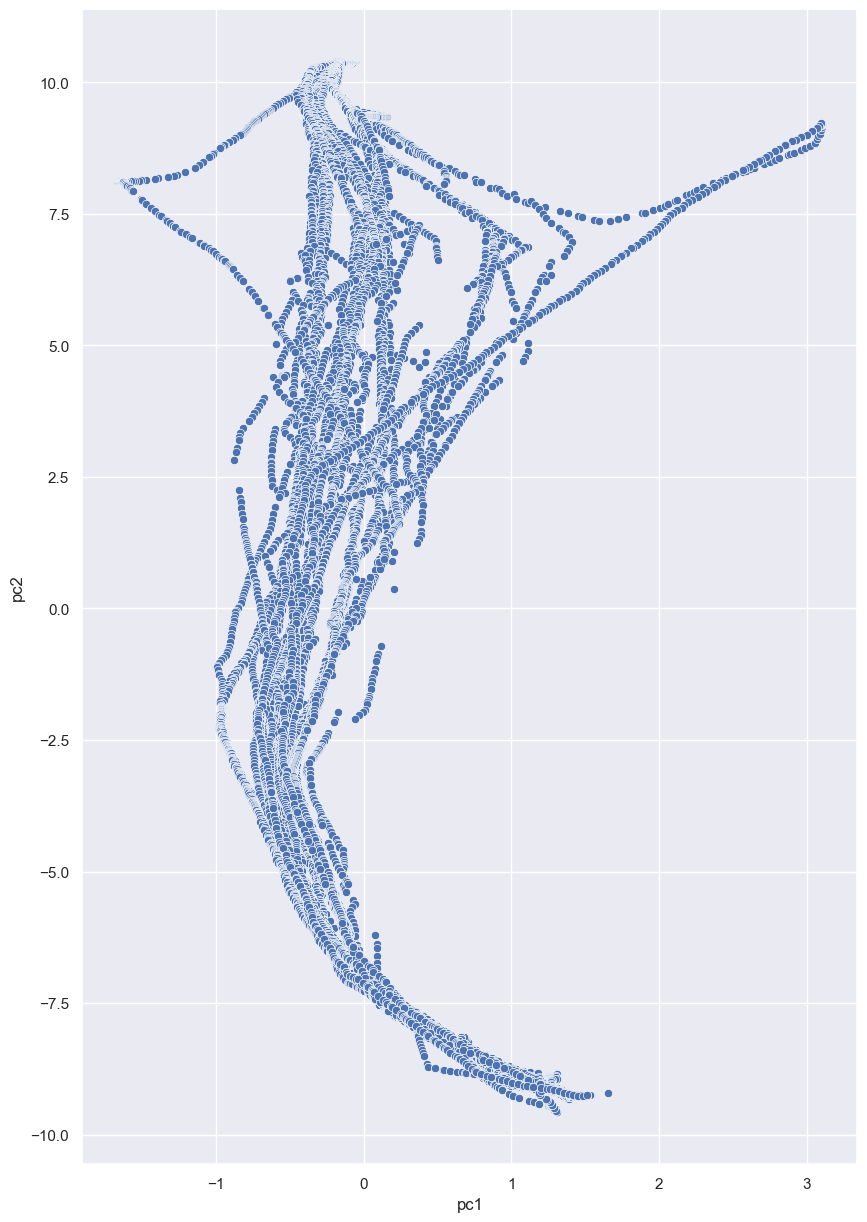

In [28]:
sns.set(rc = {'figure.figsize':(10,15)})
sns.scatterplot(data=rotated_data, x='pc1', y='pc2')
plt.legend([],[], frameon=False)
plt.show()

In [29]:
# rotated_data = rotated_data.reset_index(drop=True)
rotated_data

,pc1,pc2
0,-0.099394,10.389517
1,-0.064126,10.385011
2,-0.064004,10.384593
3,-0.101317,10.388984
4,-0.062498,10.380657
...,...,...
17408,1.388690,-9.227532
17409,1.417851,-9.251918
17410,1.451949,-9.263264
17411,1.483335,-9.260355


## 구간 나누기

In [30]:
# y축 값의 최소값과 최대값을 10등분하기 위해 sort
sorted_df = rotated_data.sort_values('pc2') 
sorted_df

# 최저값을 0으로 맞추기 위해 최저값 추출
minus = sorted_df.iloc[0,1] 
minus

# pc2의 전체 행에 최저값 빼기
rotated_data['pc2'] = rotated_data['pc2'] - minus # <- 한번 실행하면 주석처리 해주기!

# 10등분 한 값
rate = rotated_data.sort_values('pc2',ascending=False).iloc[0,1] / 10
rate

1.9957249081846637

In [31]:
rotated_data

,pc1,pc2
0,-0.099394,19.955376
1,-0.064126,19.950870
2,-0.064004,19.950452
3,-0.101317,19.954843
4,-0.062498,19.946516
...,...,...
17408,1.388690,0.338327
17409,1.417851,0.313942
17410,1.451949,0.302595
17411,1.483335,0.305504


In [32]:
part_list = []
rotated_data['part'] = 0
for i in range(len(rotated_data)):
    for num in range(0,20):
        if 1*num <= rotated_data['pc2'][i] < 1*(num+1):
            part = num
            part_list.append(part)
#     if i == (len(rotated_data)-1) :
#         part = 0
#         part_list.append(part)
        
# len(part_list)
rotated_data['part'] = part_list
rotated_data

,pc1,pc2,part
0,-0.099394,19.955376,19
1,-0.064126,19.950870,19
2,-0.064004,19.950452,19
3,-0.101317,19.954843,19
4,-0.062498,19.946516,19
...,...,...,...
17408,1.388690,0.338327,0
17409,1.417851,0.313942,0
17410,1.451949,0.302595,0
17411,1.483335,0.305504,0


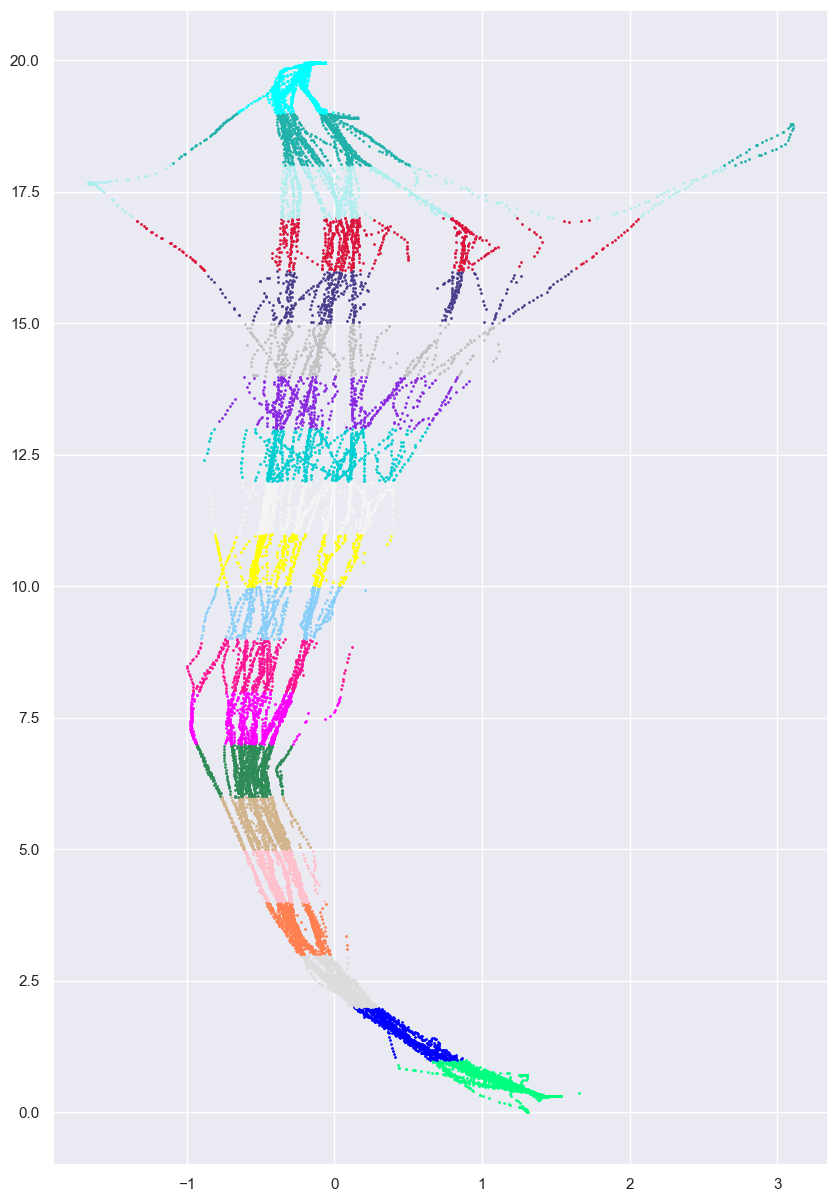

In [33]:
colors = random.sample(colors_list,20)
for i in range(20):
    plt.plot(rotated_data[rotated_data['part'] == i]['pc1'], rotated_data[rotated_data['part'] == i]['pc2'], 'o', color=colors[i], markersize=1)
    
plt.show()

In [34]:
KR2HK_full['part'] = part_list
KR2HK_full

,vsl_id,vsl_timestamp,vsl_speed,vsl_course,vsl_heading,lat,lon,path_num,소요시간,누적소요시간,distance,distance_sum,part
0,cecc287c-91df-30f6-b5bc-6946ddf5184e,2022-10-12 22:10:00,3.4,171.3,169,35.098620,129.090520,0,0 days 00:00:00,0 days 00:00:00,0.000000,0.000000,19
1,560e2d73-9137-37bd-964d-713ec0e13afb,2022-09-27 03:10:00,3.4,227.1,220,35.120090,129.062180,29,0 days 00:00:00,0 days 00:00:00,0.000000,0.000000,19
2,560e2d73-9137-37bd-964d-713ec0e13afb,2022-12-31 14:20:00,0.4,329.1,232,35.119877,129.061800,30,0 days 00:00:00,0 days 00:00:00,0.000000,0.000000,19
3,cecc287c-91df-30f6-b5bc-6946ddf5184e,2022-11-24 16:56:00,1.3,295.7,94,35.096893,129.091520,3,0 days 00:00:00,0 days 00:00:00,0.000000,0.000000,19
4,0d67e314-3d75-3de9-9440-47e265f3421f,2022-12-18 19:00:00,0.9,175.6,27,35.118120,129.057970,31,0 days 00:00:00,0 days 00:00:00,0.000000,0.000000,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17408,fcb9d93e-c155-3480-8685-db2e533dad11,2022-09-08 18:10:00,13.4,275.0,277,22.131268,114.295562,10,0 days 00:10:00,4 days 19:05:00,4.077451,2767.610055,0
17409,fcb9d93e-c155-3480-8685-db2e533dad11,2022-09-08 18:20:00,12.6,274.8,277,22.134267,114.257667,10,0 days 00:10:00,4 days 19:15:00,3.917454,2771.527509,0
17410,fcb9d93e-c155-3480-8685-db2e533dad11,2022-09-08 18:30:00,12.4,319.0,323,22.150033,114.225373,10,0 days 00:10:00,4 days 19:25:00,3.759809,2775.287319,0
17411,fcb9d93e-c155-3480-8685-db2e533dad11,2022-09-08 18:40:00,10.1,322.6,325,22.174082,114.204997,10,0 days 00:10:00,4 days 19:35:00,3.399091,2778.686410,0


## 구간별로 색 나눠서 그래프 찍어보기

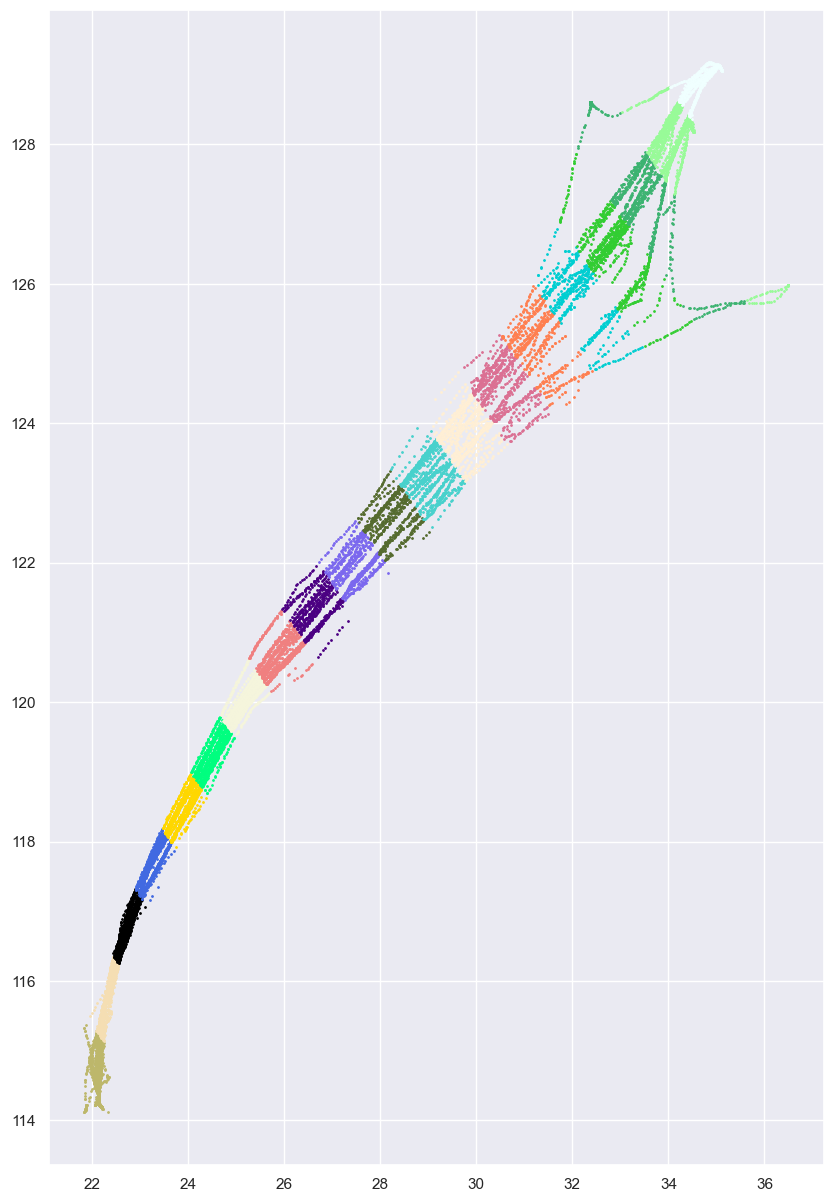

In [35]:
colors = random.sample(colors_list,20)
for i in range(20):
    plt.plot(KR2HK_full[KR2HK_full['part'] == i]['lat'], KR2HK_full[KR2HK_full['part'] == i]['lon'], 'o', color=colors[i], markersize=1)
    
plt.show()

# DBSCAN

## 위도,경도 합친 변수 만들기

In [36]:
coords = KR2HK_full[['lat', 'lon']].values
# coords

## n번째 구간 데이터만 뽑기

In [37]:
PATH_NUM = 15
path_df = KR2HK_full[KR2HK_full['part'] == PATH_NUM][['lat','lon']]
path_coords = KR2HK_full[KR2HK_full['part'] == PATH_NUM][['lat','lon']].values

## 입실론 값 구하기 - 1

In [38]:
# get distance with nearest neighbor 

def nearest_dist(df):
    norms = []
    for i in range(len(df)):
        temp_norms = []
        for j in range(len(df)):
            if i != j:
#                 norm = haversine(df[i], df[j])
                norm = np.linalg.norm(df[i]-df[j])
                temp_norms.append(norm)
        norms.append(min(temp_norms))
    return norms

In [39]:
get_eps = nearest_dist(path_coords)
eps = np.array(get_eps).mean()
eps

0.022853689746310458

## 입실론 값 구하기 - 2

In [40]:
neigh = NearestNeighbors(n_neighbors=2)

nbrs = neigh.fit(path_coords)

distances, indices = nbrs.kneighbors(path_coords)

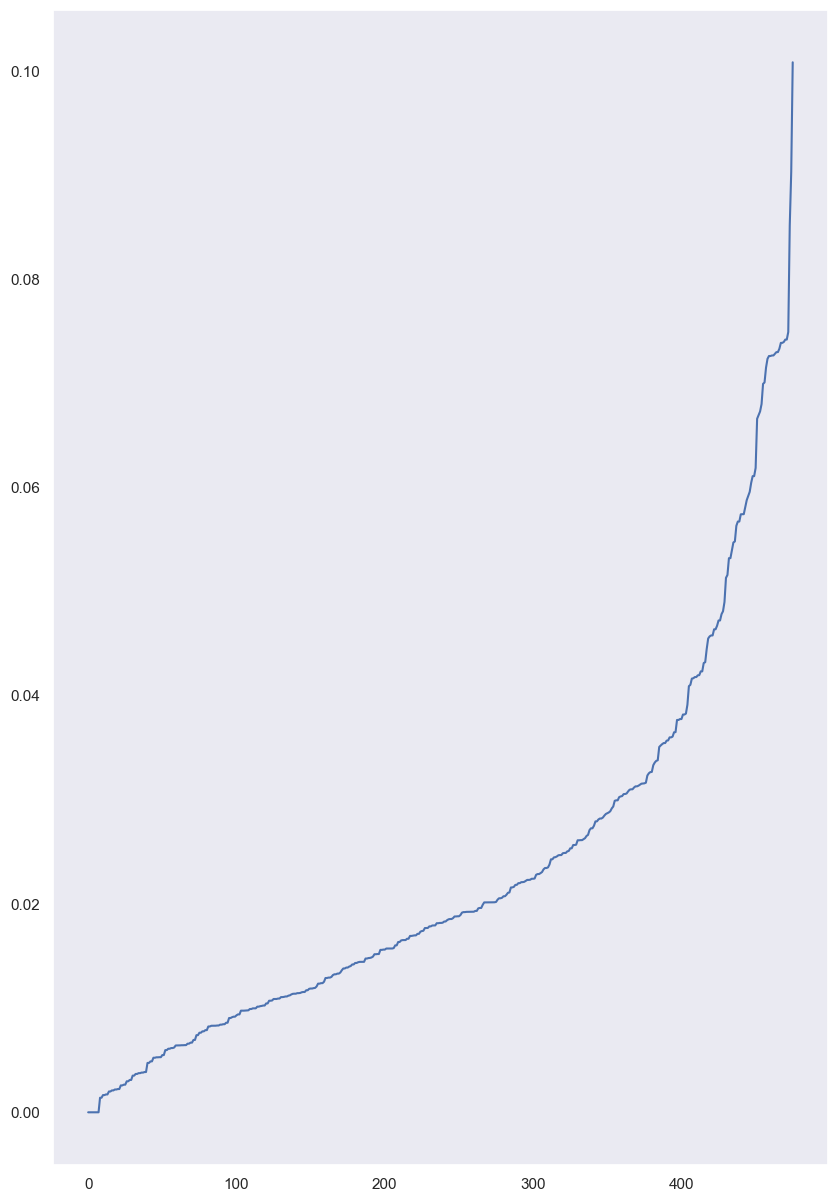

In [41]:
distances = np.sort(distances, axis=0)

distances = distances[:,1]

plt.grid()
plt.plot(distances)
plt.show()

## 클러스터링 해보기

In [42]:
dbscan = DBSCAN(eps=0.06, min_samples=2)
dbscan.fit(path_df)

clusters = dbscan.labels_
# clusters

pd.DataFrame(clusters, columns=['cluster_num']).groupby('cluster_num')[['cluster_num']].count()

,cluster_num
cluster_num,
-1,29
0,252
1,35
2,2
3,78
4,3
5,2
6,2
7,2


## 구간별 군집 누적합 비율

In [43]:
# 각 군집을 내림차순 sort해서 누적합을 구해 누적합의 값이 전체의 nn% 이상이면 자르기
df = pd.DataFrame(clusters, columns=['cluster_num']).groupby('cluster_num')[['cluster_num']].count()
df.columns = ['cluster']
drop_NA_df = df.sort_values('cluster', ascending=False).drop(-1)
drop_NA_df['cluster_num'] = drop_NA_df.index
drop_NA_df.reset_index(drop=True, inplace=True)
drop_NA_df['cumsum'] = drop_NA_df['cluster'].cumsum()
drop_NA_df['ratio'] = [drop_NA_df['cumsum'][i] / drop_NA_df['cluster'].sum() for i in range(len(drop_NA_df))]
drop_NA_df

# 14 - 90% / 16 - 90% / 17 - 90% / 15 - 90%
# 누적합 ratio가 90%가 넘는 시점의 군집까지만 살리고 그 밑 군집은 버림

,cluster,cluster_num,cumsum,ratio
0,252,0,252,0.563758
1,78,3,330,0.738255
2,35,1,365,0.816555
3,25,9,390,0.872483
4,8,18,398,0.890380
5,6,20,404,0.903803
6,6,13,410,0.917226
7,4,19,414,0.926174
8,4,12,418,0.935123
9,3,4,421,0.941834


In [44]:
path_df['cluster'] = clusters
path_df.head()

,lat,lon,cluster
3939,32.417595,126.07758,0
3940,32.422066,126.15967,0
3944,32.406820,126.14889,0
3956,32.421370,126.14990,0
3964,32.397010,126.14741,0


## 중심점 찾기
- 해당 군집에 속하는 데이터 수가 nn개 이상일 때만 군집의 중심점 찾기
- 중심점을 따라 트래킹

In [45]:
mean_coord = path_df[path_df['cluster'] == 0][['lat','lon']].mean()
mean_coord

lat     31.937095
lon    125.961187
dtype: float64

## 군집 결과 시각화 함수

In [46]:
### 클러스터 결과를 담은 DataFrame과 사이킷런의 Cluster 객체등을 인자로 받아 클러스터링 결과를 시각화하는 함수  
# clusterobj: 사이킷런의 군집 수행 객체. KMeans나 DBSCAN의 fit()와 predict()로 군집화를 완료한 객체
# dataframe: 피처 데이터 세트와 label 값을 가진 DataFrame
# label_name: 군집화 결과 시각화일 경우 DataFrame 내의 군집화 label 컬럼명
# iscenter: 사이킷런의 Cluster 객체가 군집 중심 좌표를 제공하면 True, 그렇지 않으면 False
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True, showLegend=True):
    if iscenter :
        centers = clusterobj.cluster_centers_
        
    unique_labels = np.unique(dataframe[label_name].values)
    markers=[".", ",", "o", "v", "^", "<", ">", "s", "p", "_", "+", "x", "1" ,"2", "3", 
             "4", "8", "s", "p", "P", "h", "H", "+", "D", "d", "|", "*"]
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)
        
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=20,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)
        
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
            
        plt.scatter(mean_coord[0], mean_coord[1], marker='^', s=30, color='r')
        
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'
    
    if showLegend:
        plt.legend(loc=legend_loc)
    plt.show()

## 산점도그래프 그려보기

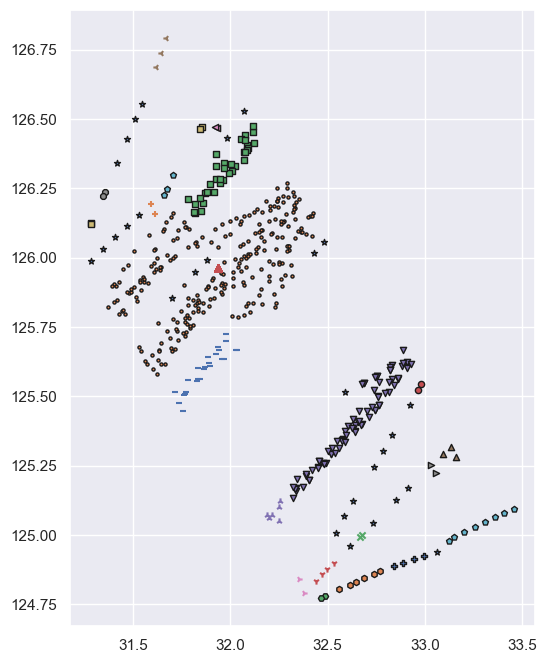

In [47]:
plt.figure(figsize=(6,8))
df1 = pd.DataFrame(path_coords, columns=['ftr1','ftr2'])
df1['cluster_num'] = clusters
visualize_cluster_plot(dbscan, df1, 'cluster_num', iscenter=False, showLegend=False)

# 지도에 구간별 데이터 찍기

In [ ]:
path_draw = draw_point(KR2HK_full, colors_list)
path_draw

# 구간별로 전부 클러스터링 하기

In [ ]:
for i in range(20):
    PATH_NUM = i
    path_df = KR2HK_full[KR2HK_full['part'] == PATH_NUM][['lat','lon']]
    path_coords = KR2HK_full[KR2HK_full['part'] == PATH_NUM][['lat','lon']].values
    dbscan = DBSCAN(eps=0.06, min_samples=2)
    dbscan.fit(path_df)

    clusters = dbscan.labels_
    
    path_df['cluster_num'] = clusters
    
    df = pd.DataFrame(clusters, columns=['cluster_num']).groupby('cluster_num')[['cluster_num']].count()
    df.columns = ['cluster']
    if -1 in df.index:
        drop_NA_df = df.sort_values('cluster', ascending=False).drop(-1)
    else:
        drop_NA_df = df.sort_values('cluster', ascending=False)
        
    drop_NA_df['cluster_num'] = drop_NA_df.index
    drop_NA_df.reset_index(drop=True, inplace=True)
    drop_NA_df['cumsum'] = drop_NA_df['cluster'].cumsum()
    drop_NA_df['ratio'] = [drop_NA_df['cumsum'][i2] / drop_NA_df['cluster'].sum() for i2 in range(len(drop_NA_df))]
    
    for i3 in range(len(drop_NA_df)):
        if drop_NA_df.loc[i2,'ratio'] >= 0.9:
            drop_NA_df = drop_NA_df[:i3+1]
            break
    
    for i4 in path_df.index:
        if not path_df.loc[i4,'cluster_num'] in drop_NA_df['cluster_num'].values:
            cluster_df = path_df.drop(i4)
    
    cluster_means = []
    for i5 in cluster_df['cluster_num'].values:
        mean_coord = cluster_df[cluster_df['cluster_num'] == i5][['lat','lon']].mean()
        cluster_means.append(mean_coord)
        

## 군집 숫자 컬럼 넣기